The use case of this problem is that we have a dataset with which has Quora Questions as the text and the target variable is a binary classification problem.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing the libraries.

In [ ]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
tqdm.pandas()

Reading the dataset.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/Quora Text Classification Data.csv')
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Creating List of Stop words in order to remove it from the text.

In [ ]:
stop_words = stopwords.words('english')+list(punctuation)
lem = WordNetLemmatizer()

Basic Cleaning process of the text.


1.   Converting the text into Lower Case
2.   Tokenizing the words into tokens
3.   Removing Stop words from the text in order to reduce the vocabulary size.
4.   Lemmatizing the words and bring them into their base form.
5.   Joining the tokenized words into simple texts again.



In [ ]:
def cleaning(text):
  text = text.lower()
  words = word_tokenize(text)
  words = [w for w in words if w not in stop_words]
  words = [lem.lemmatize(w) for w in words]
  return ' '.join(words)

In [ ]:
df['Clean Text'] = df['question_text'].progress_apply(cleaning)

100%|██████████| 1306122/1306122 [03:49<00:00, 5700.37it/s]


In [ ]:
!unzip '/content/drive/MyDrive/Word Embeddings/glove.42B.300d.zip'

Archive:  /content/drive/MyDrive/Word Embeddings/glove.42B.300d.zip
  inflating: glove.42B.300d.txt      


Loading the word embeddings from the glove text file.

In [ ]:
embedding_values = {}
f = open('/content/glove.42B.300d.txt')
for line in tqdm(f):
  value = line.split(' ')
  word = value[0]
  coef = np.array(value[1],dtype = "float32")
  if coef is not None:
    embedding_values[word] = coef

1917494it [01:44, 18363.53it/s]


In [ ]:
tokenizer = Tokenizer()
x = df['Clean Text']
y = df['target']

tokenizer.fit_on_texts(x)


seq = tokenizer.texts_to_sequences(x)
pad_seq = pad_sequences(seq,maxlen = 300)


In [ ]:
vocab_size = len(tokenizer.word_index)+1
print(vocab_size)

193365


Converting the words into embeddings

In [ ]:
embedding_matrix = np.zeros((vocab_size,300))
for word, i in tqdm(tokenizer.word_index.items()):
  value = embedding_values.get(word)
  if value is not None:
    embedding_matrix[i] = value

100%|██████████| 193364/193364 [00:00<00:00, 595800.01it/s]


Creating a deep learning model using LSTM.

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size,300,input_length=300,weights = [embedding_matrix],trainable = False))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(128,activation ='relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer = 'adam',loss='binary_crossentropy',metrics = ['accuracy'])

history = model.fit(pad_seq,y,validation_split=0.2,epochs = 5)

Epoch 1/5
32654/32654 [==============================] - 532s 16ms/step - loss: 0.2171 - accuracy: 0.9374 - val_loss: 0.2108 - val_accuracy: 0.9377
Epoch 2/5
32654/32654 [==============================] - 526s 16ms/step - loss: 0.2121 - accuracy: 0.9379 - val_loss: 0.2116 - val_accuracy: 0.9377
Epoch 3/5
32654/32654 [==============================] - 527s 16ms/step - loss: 0.2090 - accuracy: 0.9380 - val_loss: 0.2089 - val_accuracy: 0.9377
Epoch 4/5
32654/32654 [==============================] - 530s 16ms/step - loss: 0.2078 - accuracy: 0.9382 - val_loss: 0.2079 - val_accuracy: 0.9377
Epoch 5/5
32654/32654 [==============================] - 521s 16ms/step - loss: 0.2057 - accuracy: 0.9385 - val_loss: 0.2076 - val_accuracy: 0.9377


In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1,6)

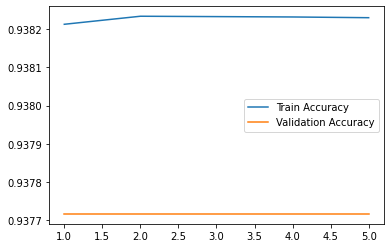

In [ ]:
plt.plot(epochs,train_acc,label = 'Train Accuracy')
plt.plot(epochs,val_acc,label = 'Validation Accuracy')
plt.legend()
plt.show()

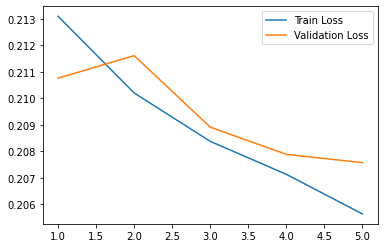

In [ ]:
plt.plot(epochs,train_loss,label = 'Train Loss')
plt.plot(epochs,val_loss,label = 'Validation Loss')
plt.legend()
plt.show()